In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [9]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [12]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [21]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [22]:
inspector.get_table_names()

['measurement', 'station']

In [23]:
columns = inspector.get_columns('measurement')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"],column["type"],primarykeystr)

id INTEGER Primary Key
station TEXT 
date TEXT 
prcp FLOAT 
tobs FLOAT 


In [24]:
columns = inspector.get_columns('station')
for column in columns:
    primarykeystr = ""
    if column['primary_key'] == 1:
        primarykeystr = "Primary Key"
    print(column["name"], column["type"], primarykeystr)

id INTEGER Primary Key
station TEXT 
name TEXT 
latitude FLOAT 
longitude FLOAT 
elevation FLOAT 


# Exploratory Precipitation Analysis

In [66]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date = most_recent_date[0]
most_recent_date

'2017-08-23'

In [67]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f"The date 1 year before the most recent date in the database is: {query_date}")

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date,Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation, columns = ["Date", "Precipitation"])
precipitation_df = precipitation_df.sort_values("Date", ascending = True)
precipitation_df = precipitation_df.set_index("Date")
precipitation_df.head()


The date 1 year before the most recent date in the database is: 2016-08-23


,Precipitation
Date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


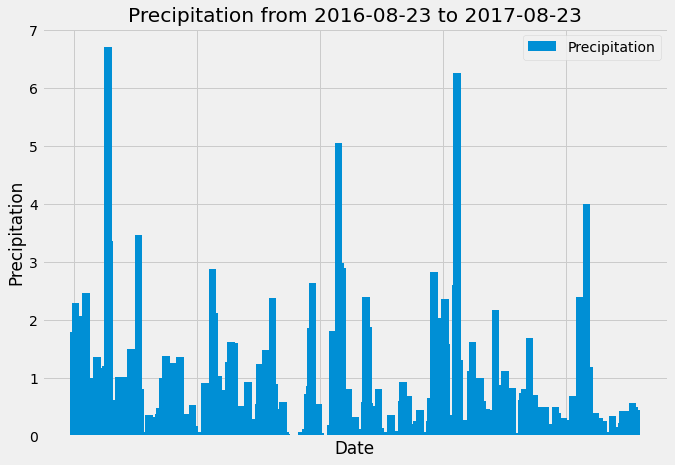

In [68]:
# Use Pandas Plotting with Matplotlib to plot the data

x_values = precipitation_df.index.tolist()
y_values = precipitation_df['Precipitation'].tolist()

plt.figure(figsize=(10,7))
plt.bar(x_values,y_values,width = 5, align="center",label='Precipitation')
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) 
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks)

plt.title(f"Precipitation from {query_date} to {most_recent_date}")
plt.xlabel("Date")
plt.ylabel("Precipitation")
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()


In [69]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [70]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.station)).all()

In [71]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_station = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [72]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
active_id = (session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).first())[0]
active_id

'USC00519281'

In [73]:
temperature = session.query(Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == active_id).all()
temperature

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

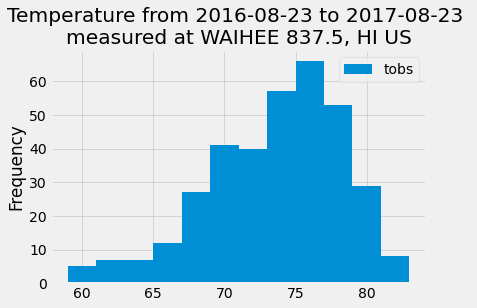

In [74]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_year = session.query(Measurement.tobs).\
    filter(Measurement.station == active_id).\
    filter(Measurement.date >= query_date).all()
temperatures = list(np.ravel(temp_year))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == active_id,"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {query_date} to {most_recent_date} \nmeasured at {stationname}")
plt.legend()

# Close session

In [75]:
# Close Session
session.close()